# Song of Bengalese finches
The song of bengalese finches has beens show to cluster into discrete syllable types, which are recoverable using unsupervised methods. 

We here closely follow the procedure described in Sainburg et al. (2020): Finding, visualizing, and quantifying latent structure across (see code on [github](https://github.com/timsainb/avgn_paper)).

In [30]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import librosa.feature
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorcet as cc
import matplotlib
import das_unsupervised.spec_utils
import umap
import hdbscan
from io import BytesIO
import urllib.request
from noisereduce.noisereducev1 import reduce_noise


%config InlineBackend.figure_format = 'jpg'  # smaller mem footprint for page
plt.style.use('ncb.mplstyle')

## Download audio data
Data of four Bengalese finches from: D Nicholson, JE Queen, S Sober (2017). Bengalese finch song repository. See [data repo](https://doi.org/10.6084/m9.figshare.4805749.v5]) on figshare.

In [31]:
url = 'https://github.com/janclemenslab/das_unsupervised/releases/download/v0.4/birds.npz'
with urllib.request.urlopen(url) as f:
    ff = BytesIO(f.read())

d = np.load(ff)
recording = d['recording']
syllable_onsets = d['syllable_onsets']
syllable_offsets = d['syllable_offsets']
syllable_types = d['syllable_types']
samplerate = d['samplerate']

## Pre-processing
Noise reduction

In [32]:
noise_clip = recording[:150_000]
x_nr = reduce_noise(audio_clip=recording, noise_clip=noise_clip, verbose=False)

Compute the spectrogram

(128,)


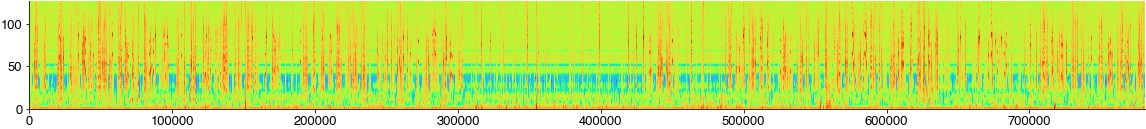

In [33]:
hop_length = int(2 * samplerate / 1000)
win_length = int(10 * samplerate / 1000 * 2)
specgram = librosa.feature.melspectrogram(x_nr, sr=samplerate, n_fft=win_length, hop_length=hop_length, power=2)
specgram = specgram[np.where(specgram[:,0]!=0)[0],:]
sm = np.median(specgram, axis=1)
print(sm.shape)
plt.figure(figsize=(20, 2))
plt.imshow(np.log2(specgram), cmap='turbo')
plt.show()

Extract and threshold syllables from spectrogram

<function matplotlib.pyplot.show(close=None, block=None)>

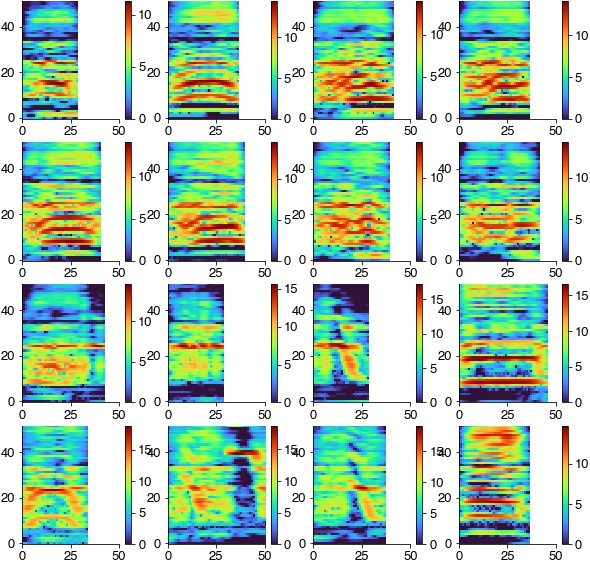

In [34]:
specs = [] 

plt.figure(figsize=(10, 10))
for cnt, (onset, offset) in enumerate(zip(syllable_onsets, syllable_offsets)):
    spec = np.log2(specgram[:, int(onset/hop_length):int(offset/hop_length)] / sm[:, np.newaxis])
    spec = spec[4:-20:2, :]
    spec = spec - 2
    spec[spec<0] = 0
    specs.append(spec)
    try:
        plt.subplot(4,4,cnt+1)
        plt.imshow(specs[-1], cmap='turbo')
        plt.xlim(0, 50)
        plt.colorbar()
    except:
        pass
plt.show

Log-scale the time axis to reduce differences in syllable duration and zero-pad all syllables to the same duration

In [35]:
spec_rs = [das_unsupervised.spec_utils.log_resize_spec(spec, scaling_factor=8) for spec in specs]

max_len = np.max([spec.shape[1] for spec in spec_rs])
spec_rs = [das_unsupervised.spec_utils.pad_spec(spec, pad_length=max_len) for spec in spec_rs]

Flatten 2D [time x freq] spectrograms to 1D feature vectors

In [36]:
spec_flat = [spec.ravel() for spec in spec_rs]
spec_flat = np.array(spec_flat)

## Dimensionality reduction and clustering
Embed the feature vectors into a 2D space using [UMAP](https://umap-learn.readthedocs.io/) and cluster the resulting groups of syllables with [hdbscan](https://hdbscan.readthedocs.io/).

In [37]:
out = umap.UMAP(min_dist=0.5, random_state=2).fit_transform(spec_flat)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20).fit_predict(out)

/Users/clemens10/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


## Plot results
Syllable spectrograms embedded into a 2D space, colored by manual syllable labels (left) and by the unsupervised cluster labels (right). 
Syllables fall into separate groups, which are consistent with the grouping imposed by manual labelling (left, syllables of the same label are grouped together). The clustering (right) recovers the manual separation by tends to find  more subdivisions.

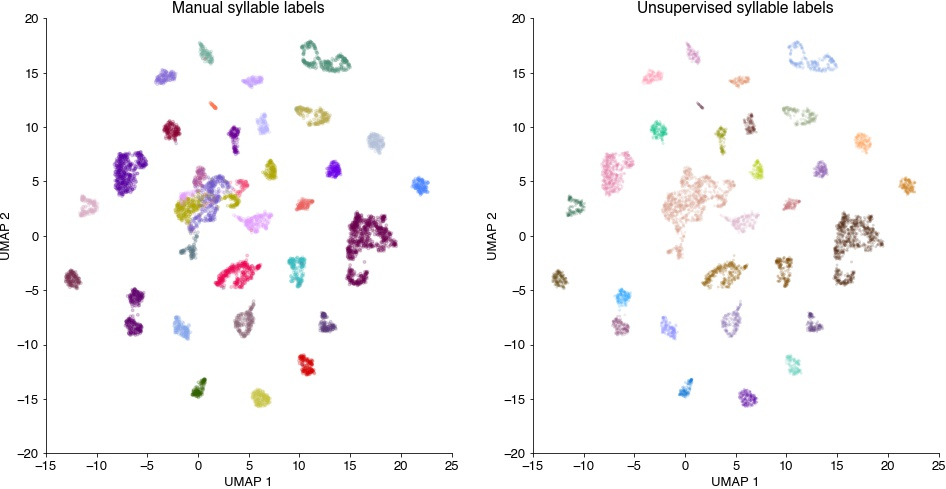

In [38]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(out[:,0], out[:,1], c=syllable_types, cmap='cet_glasbey_dark', alpha=0.2, s=8)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Manual syllable labels')

# colormap with cluster label 0 (outliers) grey
cmap = cc.palette['glasbey_dark']
cmap = list(cmap)
cmap.insert(0, (0.7, 0.7, 0.7))
cmap = ListedColormap(cmap)

plt.subplot(122)
plt.scatter(out[:,0], out[:,1], c=hdbscan_labels, cmap=cmap, alpha=0.2, s=8, edgecolor='none')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Unsupervised syllable labels')

plt.show()

Confusion matrix to compare manual and cluster syllable labels. Most syllables are assigned a single cluster labels.

 Homogeneity_score: 0.91
 Completeness_score: 0.96
 V_measure_score: 0.94


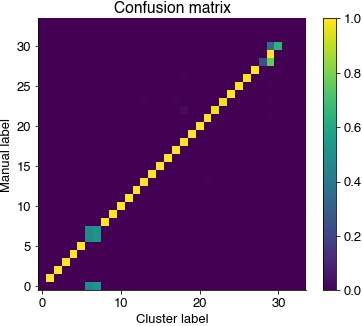

In [39]:
uni, syllable_types_relabeled = np.unique(syllable_types, return_inverse=True)  # remove non-used labels
C = sklearn.metrics.confusion_matrix(syllable_types_relabeled, hdbscan_labels, normalize='true')
idx = np.argmax(C, axis=0)  # re-order columns

plt.figure(figsize=(6, 5))
plt.imshow(C[idx, :])
plt.colorbar()
plt.title('Confusion matrix')
plt.ylabel('Manual label')
plt.xlabel('Cluster label')

print(f' Homogeneity_score: {sklearn.metrics.homogeneity_score(syllable_types, hdbscan_labels):1.2f}\n',
      f'Completeness_score: {sklearn.metrics.completeness_score(syllable_types, hdbscan_labels):1.2f}\n',
      f'V_measure_score: {sklearn.metrics.v_measure_score(syllable_types, hdbscan_labels):1.2f}')

Average spectrograms of the syllables in each cluster reveal the spectral features that discriminat syllables.

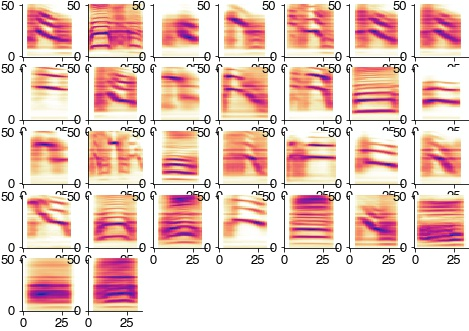

In [40]:
  plt.figure(figsize=(8, 8))
  for label in np.unique(hdbscan_labels):
      if label>=0:
        idx = np.where(hdbscan_labels==label)[0]
        plt.subplot(7, 7, label+1)
        plt.imshow(np.mean(np.array(spec_rs)[idx], axis=0), cmap='cet_CET_L17')
